<a href="https://colab.research.google.com/github/yewonlee5/yewonlee5.github.io/blob/main/Siamese%20Neural%20Networks%20(Thesis)/THESIS_MODEL1_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import os

# How many categories?
path = r"/content/drive/MyDrive/thesis/train/"

dir_list = os.listdir(path)

len(dir_list)


352

In [ ]:
# How many total data?
path = r"/content/drive/MyDrive/thesis/train/"

l=[]
for path, subdirs, files in os.walk(path):
  for name in files:
    l.append(os.path.join(path, name))

len(l)

15165

In [ ]:
# How many training data?
path = r"/content/drive/MyDrive/thesis/output/train/"

l=[]
for path, subdirs, files in os.walk(path):
  for name in files:
    l.append(os.path.join(path, name))

len(l)

11984

In [ ]:
# How many validating data?
path = r"/content/drive/MyDrive/thesis/output/val/"

l=[]
for path, subdirs, files in os.walk(path):
  for name in files:
    l.append(os.path.join(path, name))

len(l)

1368

In [ ]:
# How many testing data?
path = r"/content/drive/MyDrive/thesis/output/test/"

l=[]
for path, subdirs, files in os.walk(path):
  for name in files:
    l.append(os.path.join(path, name))

len(l)

1811

In [ ]:
# https://medium.com/hackernoon/facial-similarity-with-siamese-networks-in-pytorch-9642aa9db2f7

# imports

%matplotlib inline
import torchvision
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader,Dataset
import matplotlib.pyplot as plt
import torchvision.utils
import numpy as np
import pandas as pd
import random
from PIL import Image
import torch
from torch.autograd import Variable
import PIL.ImageOps
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import torchvision.transforms.functional as F2

In [ ]:
# help functions

def imshow(img,text=None,should_save=False):
    npimg = img.numpy()
    plt.axis("off")
    if text:
        plt.text(75, 8, text, style='italic',fontweight='bold',
            bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

def show_plot(iteration,loss):
    plt.plot(iteration,loss)
    plt.show()

In [ ]:
# configurations

class Config():
    training_dir = "./drive/MyDrive/thesis/output/train/"
    validating_dir = "./drive/MyDrive/thesis/output/val/"
    testing_dir = "./drive/MyDrive/thesis/output/test/"
    train_batch_size = 64
    train_number_epochs = 100

In [ ]:
# The folder contains a subfolder for each class of shape

import os

classes = sorted(os.listdir(Config.training_dir))
num_classes = len(classes)
print(num_classes)

352


In [ ]:
# Define WhitePad

class WhitePad:
  def __call__(self, image):
    max_wh = max(image.size)
    p_left, p_top = [(max_wh - s)//2 for s in image.size]
    p_right, p_bottom = [max_wh - (s + pad) for s, pad in zip(image.size, [p_left, p_top])]
    padding = (p_left, p_top, p_right, p_bottom)
    return F2.pad(image, padding, 255, 'constant')



In [ ]:
# simple CNN transform

transform=transforms.Compose([
    WhitePad(),
    transforms.Resize((100,100)),
    transforms.Grayscale(),
    transforms.ToTensor()
    ])

In [ ]:
# image folder dataset

folder_dataset = dset.ImageFolder(root=Config.training_dir, transform=transform)
folder_dataset_val = dset.ImageFolder(root=Config.validating_dir, transform=transform)

In [ ]:
# data loaders
train_loader = DataLoader(
    folder_dataset, batch_size=Config.train_batch_size, shuffle=True,
    num_workers=4, pin_memory=True
)

val_loader = DataLoader(
    folder_dataset_val, batch_size=Config.train_batch_size, shuffle=False,
    num_workers=4, pin_memory=True
)

In [ ]:
# https://www.kaggle.com/code/androbomb/using-cnn-to-classify-images-w-pytorch
# https://medium.com/thecyphy/train-cnn-model-with-pytorch-21dafb918f48

# Create a neural net class
class Net(nn.Module):


    # Defining the Constructor
    def __init__(self, num_classes=num_classes):
        super(Net, self).__init__()

        # In the init function, we define each layer we will use in our model

        # Grey scale images : input channels = 1
        # We will apply 4 filters in the first convolutional layer
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=4, kernel_size=3, stride=1, padding=1)

        # A second convolutional layer takes 4 input channels, and generates 8 outputs
        self.conv2 = nn.Conv2d(in_channels=4, out_channels=8, kernel_size=3, stride=1, padding=1)

        # We in the end apply max pooling with a kernel size of 2
        self.pool = nn.MaxPool2d(kernel_size=2)

        # A drop layer deletes 20% of the features to help prevent overfitting
        # self.drop = nn.Dropout2d(p=0.2)

        # Our 100x100 image tensors will be pooled twice with a kernel size of 2. 100/2/2 is 25.
        # This means that our feature tensors are now 25 x 25, and we've generated 8 of them

        # We need to flatten these in order to feed them to a fully-connected layer
        self.fc = nn.Linear(in_features=25 * 25 * 8, out_features=num_classes)

    def forward(self, x):
        # In the forward function, pass the data through the layers we defined in the init function

        # Use a ReLU activation function after layer 1 (convolution 1 and pool)
        x = F.relu(self.pool(self.conv1(x)))

        # Use a ReLU activation function after layer 2
        x = F.relu(self.pool(self.conv2(x)))

        # Select some features to drop to prevent overfitting (only drop during training)
        # x = F.dropout(self.drop(x), training=self.training)

        # Flatten
        x = x.view((-1, 25 * 25 * 8)) # -1, x.size(0)
        # Feed to fully-connected layer to predict class
        x = self.fc(x)
        # Return class probabilities via a log_softmax function
        return torch.log_softmax(x, dim=1)


Net = Net(num_classes).cuda()
# Net = Net(num_classes).cpu()

print(Net)

Net(
  (conv1): Conv2d(1, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(4, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc): Linear(in_features=5000, out_features=352, bias=True)
)


In [ ]:
# training
def train(model, train_loader, optimizer, epoch):
    # Set the model to training mode
    model.train()
    train_loss = 0
    correct = 0
    # Process the images in batches
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.cuda(), target.cuda()
        # data, target = data.cpu(), target.cpu()

        # Reset the optimizer
        optimizer.zero_grad()

        # Push the data forward through the model layers
        output = model(data)

        # Get the loss
        loss = loss_criteria(output, target)

        # Keep a running total
        train_loss += loss.item()

        # Backpropagate
        loss.backward()
        optimizer.step()

        # Print metrics so we see some progress
        # print('\tTraining batch {} Loss: {:.6f}'.format(batch_idx + 1, loss.item()))

        # Calculate the accuracy for this batch
        _, predicted = torch.max(output.data, 1)
        correct += torch.sum(target==predicted).item()

    # return average loss for the epoch
    avg_loss = train_loss / (batch_idx+1)
    train_accuracy = correct/len(train_loader.dataset)
    print('Training set: Average loss: {:.6f}, Train Accuracy: {:.6f}'.format(avg_loss, train_accuracy))
    return avg_loss, train_accuracy

In [ ]:
def validation(model, val_loader):
    # Switch the model to evaluation mode (so we don't backpropagate or drop)
    model.eval()
    val_loss = 0
    correct = 0
    with torch.no_grad():
        batch_count = 0
        for data, target in val_loader:
            batch_count += 1
            data, target = data.cuda(), target.cuda()
            # data, target = data.cpu(), target.cpu()

            # Get the predicted classes for this batch
            output = model(data)

            # Calculate the loss for this batch
            val_loss += loss_criteria(output, target).item()

            # Calculate the accuracy for this batch
            _, predicted = torch.max(output.data, 1)
            correct += torch.sum(target==predicted).item()

    # Calculate the average loss and total accuracy for this epoch
    avg_loss = val_loss / batch_count
    val_accuracy = correct / len(val_loader.dataset)
    print('Validation set: Average loss: {:.6f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        avg_loss, correct, len(val_loader.dataset),
        100. * correct / len(val_loader.dataset)))

    # return average loss for the epoch
    return avg_loss, val_accuracy

In [ ]:
# Cross Entropy
from torch.nn import CrossEntropyLoss

optimizer = optim.Adam(Net.parameters(), lr = 0.0005 )

loss_criteria = CrossEntropyLoss()

# Resume training

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/thesis/model1_loss_accuracy.csv', index_col=0)

In [ ]:
training_loss = list(df['training_loss'])
validation_loss = list(df['validation_loss'])
training_accuracy = list(df['training_accuracy'])
validation_accuracy = list(df['validation_accuracy'])

In [ ]:
# load the model checkpoint
checkpoint = torch.load('/content/drive/MyDrive/thesis/checkpoint_CNN_50.pth')
# load model weights state_dict
Net.load_state_dict(checkpoint['model_state_dict'])
print('Previously trained model weights state_dict loaded...')
# load trained optimizer state_dict
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
print('Previously trained optimizer state_dict loaded...')
epochs = checkpoint['epoch']
# load the criterion
loss_criteria = checkpoint['loss']
print('Trained model loss function loaded...')
print(f"Previously trained for {epochs} number of epochs...")
# train for more epochs
# epochs = new_epochs
# print(f"Train for {epochs} more epochs...")

Previously trained model weights state_dict loaded...
Previously trained optimizer state_dict loaded...
Trained model loss function loaded...
Previously trained for 76 number of epochs...


In [ ]:
# Track metrics in these arrays
epoch_nums = []
# training_loss = []
# validation_loss = []
# training_accuracy = []
# validation_accuracy = []


# Execution time
import time

# get starting time
start = time.time()



# Train
for epoch in range(1 + 76, Config.train_number_epochs + 1 + 76):
        print('Epoch : {}'.format(epoch))
        train_loss, train_accuracy = train(Net, train_loader, optimizer, Config.train_number_epochs)

        elapsed_time = (time.time() - start)
        print('Accumulative Training Time : {}'.format(elapsed_time))

        val_loss, val_accuracy = validation(Net, val_loader)
        epoch_nums.append(epoch)
        training_loss.append(train_loss)
        validation_loss.append(val_loss)

        training_accuracy.append(train_accuracy)
        validation_accuracy.append(val_accuracy)

        # For each epoch, save model checkpoint
        torch.save({
            'epoch': epoch,
            'model_state_dict': Net.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss_criteria,
            }, '/content/drive/MyDrive/thesis/checkpoint_CNN_100.pth')

        # For each epoch, save loss & accuracy
        df = pd.DataFrame({'training_loss': training_loss, 'validation_loss': validation_loss, 'training_accuracy': training_accuracy, 'validation_accuracy': validation_accuracy} )
        df.to_csv('/content/drive/MyDrive/thesis/model1_loss_accuracy_2.csv')




elapsed_time = (time.time() - start)
print("Finished Training")
print(elapsed_time)

Epoch : 77
Training set: Average loss: 0.014591, Train Accuracy: 0.997079
Accumulative Training Time : 3078.1438155174255
Validation set: Average loss: 65.401416, Accuracy: 1/1368 (0%)

Epoch : 78
Training set: Average loss: 0.013351, Train Accuracy: 0.997079
Accumulative Training Time : 3828.4214947223663
Validation set: Average loss: 66.129977, Accuracy: 1/1368 (0%)

Epoch : 79
Training set: Average loss: 0.013351, Train Accuracy: 0.997246
Accumulative Training Time : 4246.32093834877
Validation set: Average loss: 66.798139, Accuracy: 1/1368 (0%)

Epoch : 80
Training set: Average loss: 0.012665, Train Accuracy: 0.997330
Accumulative Training Time : 4655.174722909927
Validation set: Average loss: 64.848448, Accuracy: 1/1368 (0%)

Epoch : 81
Training set: Average loss: 0.019503, Train Accuracy: 0.994993
Accumulative Training Time : 5062.316071271896
Validation set: Average loss: 66.229185, Accuracy: 1/1368 (0%)

Epoch : 82
Training set: Average loss: 0.037449, Train Accuracy: 0.989403


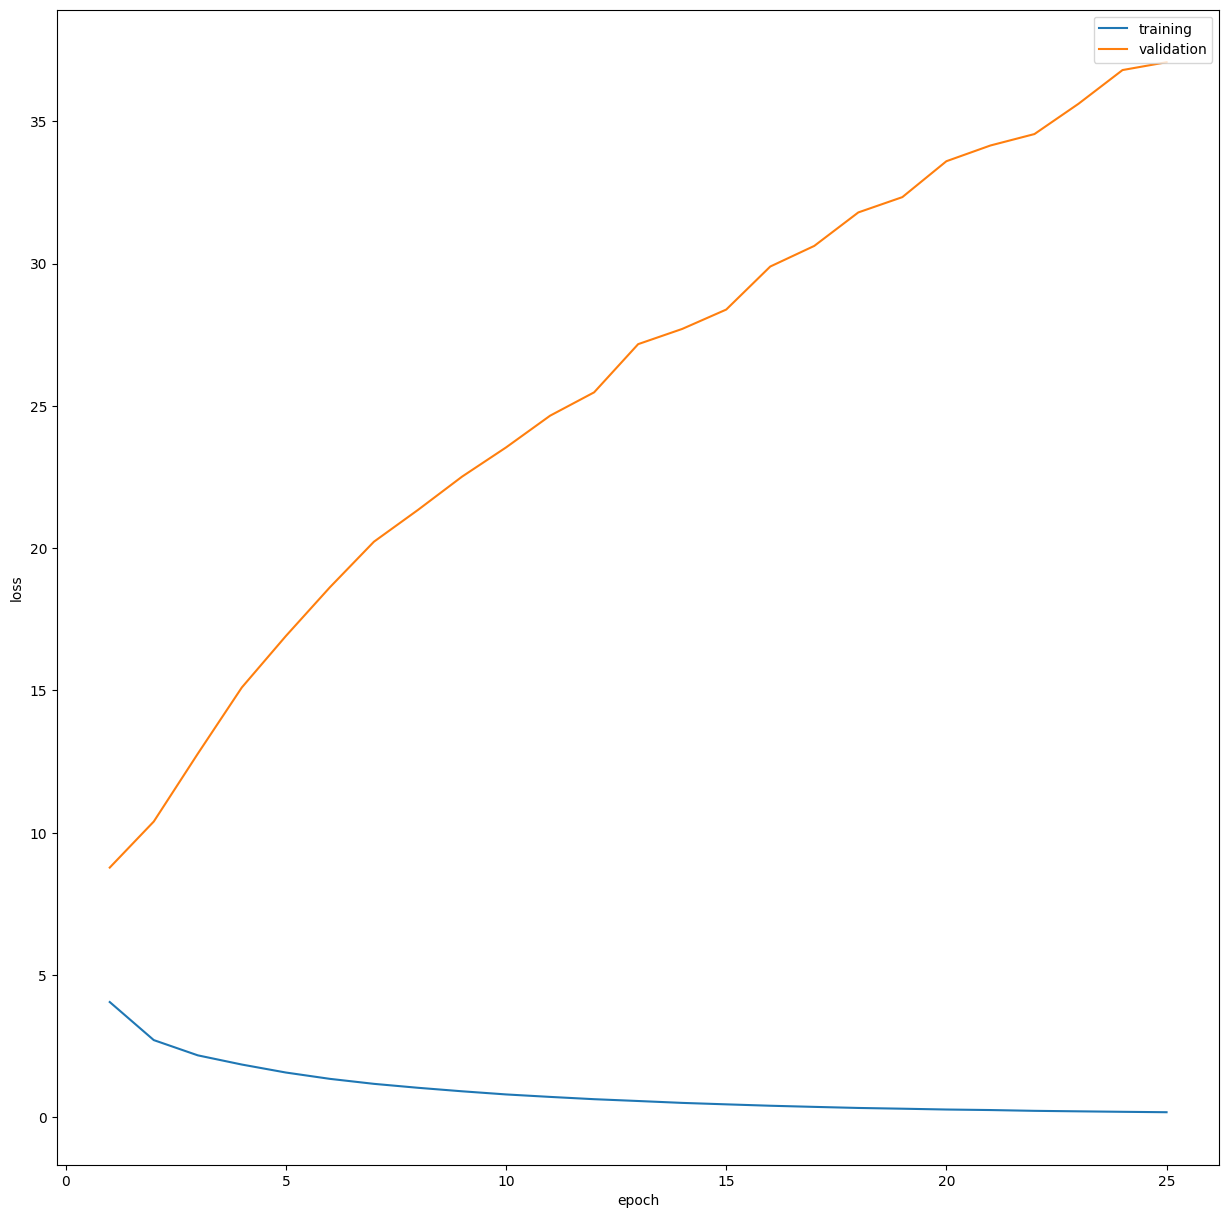

In [ ]:
# Loss History

plt.figure(figsize=(15,15))
plt.plot(epoch_nums, training_loss)
plt.plot(epoch_nums, validation_loss)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['training', 'validation'], loc='upper right')
plt.show()

In [ ]:
torch.save({
            'epoch': Config.train_number_epochs,
            'model_state_dict': Net.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss_criteria,
            }, '/content/drive/MyDrive/thesis/checkpoint_CNN_50.pth')

In [ ]:
# load the model checkpoint
checkpoint = torch.load('/content/drive/MyDrive/thesis/checkpoint_CNN_50.pth')
# load model weights state_dict
Net.load_state_dict(checkpoint['model_state_dict'])
print('Previously trained model weights state_dict loaded...')
# load trained optimizer state_dict
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
print('Previously trained optimizer state_dict loaded...')
epochs = checkpoint['epoch']
# load the criterion
loss_criteria = checkpoint['loss']
print('Trained model loss function loaded...')
print(f"Previously trained for {epochs} number of epochs...")
# train for more epochs
epochs = new_epochs
print(f"Train for {epochs} more epochs...")

<ipython-input-30-7756a38fd3e2>:6: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-darkgrid")


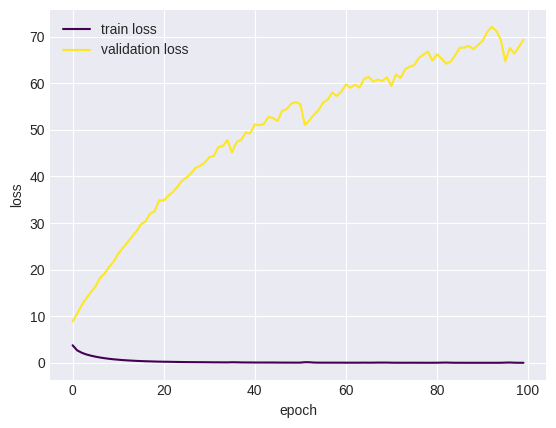

In [ ]:
# Loss History _ 100
total_epochs = 100

x = [i for i in range(total_epochs)]

plt.style.use("seaborn-darkgrid")

plt.plot(x, training_loss, label = "train loss", color = '#440154')
plt.plot(x, validation_loss, label = "validation loss", color = '#fde725')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.viridis()
plt.legend()
plt.show()

<ipython-input-31-58ea1ed40c3f>:6: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-darkgrid")


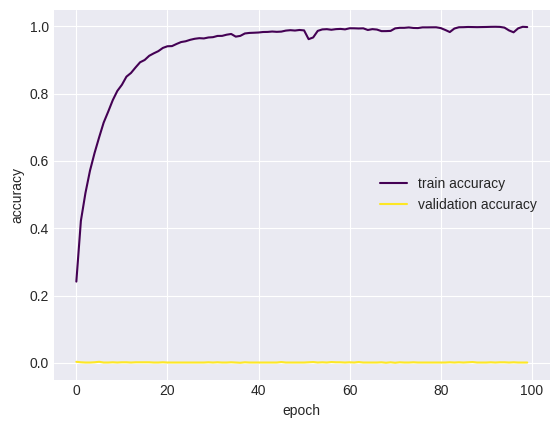

In [ ]:
# Accuracy History _ 100


x = [i for i in range(total_epochs)]

plt.style.use("seaborn-darkgrid")

plt.plot(x, training_accuracy, label = "train accuracy", color = '#440154')
plt.plot(x, validation_accuracy, label = "validation accuracy", color = '#fde725')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.viridis()
plt.legend()
plt.show()

In [ ]:
# save
torch.save(Net.state_dict(), '/content/drive/MyDrive/thesis/checkpoint_CNN_100.pth')

In [ ]:
# load the state
state_dict = torch.load(r"/content/drive/MyDrive/thesis/checkpoint_CNN_100.pth")

# load the state dict into the model
Net.load_state_dict(state_dict)

<All keys matched successfully>

In [ ]:
# test
folder_dataset_test = dset.ImageFolder(root=Config.testing_dir, transform=transform)

test_loader = DataLoader(folder_dataset_test,num_workers=6,batch_size=1,shuffle=True)


In [ ]:
# Test Accuracy Check with test dataset

truelabels = []
predictions = []
Net.eval()
print("Getting predictions from test set...")
for data, target in test_loader:
    data, target= data.cuda(), target.cuda()

    for label in target.data.cpu().numpy(): #target.data.numpy()
        truelabels.append(label)
    for prediction in Net(data).data.cpu().numpy().argmax(1): #Net(data).data.numpy().argmax(1)
        predictions.append(prediction)

Getting predictions from test set...


In [ ]:
# epoch 25

t_result = 0

for i in range(len(truelabels)):
  if truelabels[i] == predictions[i]:
    t_result += 1


# for i, j in truelabels, predictions:
#   if i==j:
#     t_result += 1
Accuracy = t_result / len(truelabels)
print(Accuracy)

0.5080066261733849


In [ ]:
# epoch 100

t_result = 0

for i in range(len(truelabels)):
  if truelabels[i] == predictions[i]:
    t_result += 1


# for i, j in truelabels, predictions:
#   if i==j:
#     t_result += 1
Accuracy = t_result / len(truelabels)
print(Accuracy)

0.5140806184428492
